# **Bulldozer sales price estimation using Machine Learning**
This notebook explores some of the basic datascience and machine learning concepts by trying to solve the problem of Bulldozers sales price prediction.  
Since the desired outcome here is an estimate of future sales price(predicting a number) this is a **Regression** problem.  

**Problem statement:**  
> Can the future sales price of a bulldozer be predicted the machine learning techniques and models?  

**Data to solve the problem:**  
The data is taken from the *Blue Book for Bulldozers Kaggle Competition*.[(link here)](https://www.kaggle.com/c/bluebook-for-bulldozers/data)  
The data for this competition is split into three parts:

1. Train.csv is the training set, which contains data through the end of 2011.
2. Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012.
3. Test.csv is the test set. It contains data from May 1, 2012 - November 2012.

The key fields are in train.csv are:

- SalesID: the uniue identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale  

Since this data contains data points indexed in time order(in `saledate` feature), this dataset is a **Timeseries data.**

Other than this there is a [data dictionary](https://drive.google.com/file/d/1qhPAQSFWw3rgpiMy88tMJInP0VGmoSj5/view?usp=sharing) provided with this dataset to understand more about the features of the data.  

---

## 0. Importing all necessary tools

In [2]:
# Data analysis and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Regression models from Scikit-learn library
from sklearn.ensemble import RandomForestRegressor

# Model evaluation and experimentation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.model_selection import  RandomizedSearchCV, GridSearchCV, cross_val_score

# saving the model
import joblib

## 1. Data loading and EDA
**Note:**  
> Data files are downloaded from [kaggle competition page](https://www.kaggle.com/c/bluebook-for-bulldozers/data) and uploaded to google drive in order to import and use it here in this notebook.  
Anyone can view the data folder used here, from this [link.](https://drive.google.com/drive/folders/1GzNp18zvT9JBbEsyjYSQnk_6mUecO6Aq?usp=sharing)  

Loading the dataset from the data folder and saving it as Pandas DataFrame. Then perform some exploratory data analysis(EDA) on the saved DataFrame.

In [3]:
# importing data from google drive folder
## since this is a timeseries data, the time feature need to be parsed into datetim object
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bulldozer-price-prediction-data/TrainAndValid.csv",
                   parse_dates=["saledate"])
# back up the origianl data inorder to reuse it when data manipulation goes wrong
original_data = data.copy()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# little preview of the data
data.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# features in the data
data.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [6]:
# what type of data this dataset hold?
data.dtypes

SalesID                              int64
SalePrice                          float64
MachineID                            int64
ModelID                              int64
datasource                           int64
auctioneerID                       float64
YearMade                             int64
MachineHoursCurrentMeter           float64
UsageBand                           object
saledate                    datetime64[ns]
fiModelDesc                         object
fiBaseModel                         object
fiSecondaryDesc                     object
fiModelSeries                       object
fiModelDescriptor                   object
ProductSize                         object
fiProductClassDesc                  object
state                               object
ProductGroup                        object
ProductGroupDesc                    object
Drive_System                        object
Enclosure                           object
Forks                               object
Pad_Type   

In [7]:
# are there any missing values?
data.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

So there are (lot of) missing values in the dataset and all the values present are also not in numeric data type.

### 1.1 Playing with the dataset by `saledate` feature

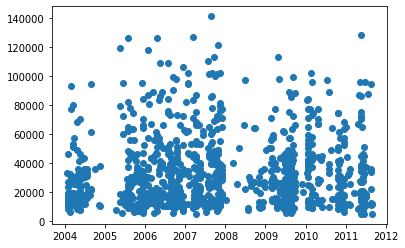

In [8]:
# visualizing the spread of saleprice over the saleyear
fig, ax = plt.subplots()
ax.scatter(data["saledate"][:1000], data["SalePrice"][:1000]);

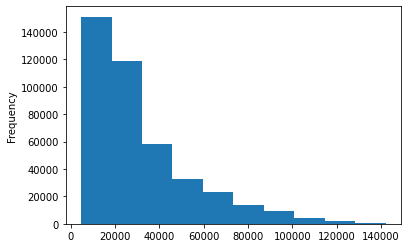

In [9]:
# looking the SalePrice distribution
data["SalePrice"].plot.hist();

In [10]:
# viewing the time stamp data
data["saledate"]

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
412693   2012-03-07
412694   2012-01-28
412695   2012-01-28
412696   2012-03-07
412697   2012-01-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

The time series data is not sorted

In [11]:
# sort the examples by dateime order
data.sort_values(by="saledate", inplace=True)

In [12]:
# creating date, month and year columns from saledate column
## since the saledate column is as pandas.datatime object, the different datetime attributes can be accessed
data["SaleDay"] = data["saledate"].dt.day
data["SaleMonth"] = data["saledate"].dt.month
data["SaleYear"] = data["saledate"].dt.year

In [13]:
# dropping saledate column as there is no need that anymore
data.drop(columns="saledate", inplace=True)

### 1.2 Filling missing values & Converting non-numeric dtypes to numeric
Need to rectify missing values and non-numeric values problems in the dataset before modeling
#### 1.2.1 Changing Object dtype data into Pandas Categorical Datatype

In [14]:
# loop to check and convert string data into Pandas categorical data
for col_name, content in data.items():
    if pd.api.types.is_string_dtype(content):
        data[col_name] = content.astype("category").cat.as_ordered()

In [15]:
# checking the conversion
data.dtypes

SalesID                        int64
SalePrice                    float64
MachineID                      int64
ModelID                        int64
datasource                     int64
auctioneerID                 float64
YearMade                       int64
MachineHoursCurrentMeter     float64
UsageBand                   category
fiModelDesc                 category
fiBaseModel                 category
fiSecondaryDesc             category
fiModelSeries               category
fiModelDescriptor           category
ProductSize                 category
fiProductClassDesc          category
state                       category
ProductGroup                category
ProductGroupDesc            category
Drive_System                category
Enclosure                   category
Forks                       category
Pad_Type                    category
Ride_Control                category
Stick                       category
Transmission                category
Turbocharged                category
B

#### 1.2.2 Filling numeric missing values with median value

In [16]:
# loop to check and fill numeric missing values with median value
for col_name, content in data.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isna(content).sum():
            # creating a column to check whether the value in that column is a filled value or not
            data[col_name+"_is_missing"] = content.isna()
            # fill missing values
            data[col_name].fillna(content.median(), inplace=True)

#### 1.2.3 Filling non-numeric(categorical) missing values and/by turning them into numbers

In [17]:
# Turn categorical variables into numbers
for col_name, content in data.items():
    # Check columns which *aren't* numeric
    if not pd.api.types.is_numeric_dtype(content):
        # check non-numeric columns with missing values
        if pd.isna(content).sum():
            # Add a column to inidicate whether sample had missing value
            data[col_name+"_is_missing"] = content.isna()
        # filing and converting values outside of (second)if block so all categorical columns get converted
        data[col_name] = pd.Categorical(content).codes+1
        # accessing "content" values' "Categorical" form and their "codes" and adding "+1"
        ## Categoric form fills "-1" for missing values, so adding "+1" means filling missing values with '+ve' numbers

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 95 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   SalesID                              412698 non-null  int64  
 1   SalePrice                            412698 non-null  float64
 2   MachineID                            412698 non-null  int64  
 3   ModelID                              412698 non-null  int64  
 4   datasource                           412698 non-null  int64  
 5   auctioneerID                         412698 non-null  float64
 6   YearMade                             412698 non-null  int64  
 7   MachineHoursCurrentMeter             412698 non-null  float64
 8   UsageBand                            412698 non-null  int8   
 9   fiModelDesc                          412698 non-null  int16  
 10  fiBaseModel                          412698 non-null  int16  
 11  fiSecond

#### 1.2.4 Save processed dataset into a new `.csv` file

In [19]:
data.to_csv("/content/drive/MyDrive/Colab Notebooks/bulldozer-price-prediction-data/processed_data.csv", index=False)

## 2. Model building

As this is a regression problem the regression model `RandomForestRegressor` from the Scikit-Learn framework is used to predict the future sale prizes.

### 2.1 Baseline model and score

Model training with all the preprocessed data and trying score on the same data.

In [20]:
# checking the time to execute this cell
%%time
# model instantiation
baseline_model = RandomForestRegressor(random_state=9)
# fit the model
baseline_model.fit(data.drop(columns="SalePrice"), data["SalePrice"])

CPU times: user 13min 43s, sys: 4.21 s, total: 13min 47s
Wall time: 13min 46s


The model is perfect and it is not throwing error but it took some time to execute. That's because the size of the data(number of samples) is huge.  
Need to reduce the time to train the model by trying different methods.

In [21]:
# check the score of the model on the same data
baseline_model.score(data.drop(columns="SalePrice"), data["SalePrice"])

0.9875413704332302

That is a good score but it is evaluated on the same data which is used to train the model. So this is not the right way to evaluate a model.  

### 2.2 Spliting train and valid sets, then features[X] & target label[y]

According to [Kaggle Blue Book for Bulldozers data description](https://www.kaggle.com/c/bluebook-for-bulldozers/data),  
- Train Data = data through the end of 2011.
- Validation Data = data from January 1, 2012 - April 30, 2012.
- Test Data =  data from May 1, 2012 - November 2012.  

So the usual method of randomly splitting the data into train and test sets using something like `train_test_split()` wouldn't work.  
Instead the data is split into train and vaild sets using the timestamp like `SaleYear`

In [22]:
# checking saleyear values in asceding order
data["SaleYear"].value_counts().sort_index()

1989     4806
1990     4529
1991     5109
1992     5519
1993     6303
1994     7929
1995     8530
1996     8829
1997     9785
1998    13046
1999    12793
2000    17415
2001    17594
2002    17246
2003    15254
2004    19879
2005    20463
2006    21685
2007    32208
2008    39767
2009    43849
2010    33390
2011    35197
2012    11573
Name: SaleYear, dtype: int64

In [23]:
# make train set with data till 2011 -> means data except 2012
data_train = data[data["SaleYear"] != 2012]
# make validation set with data from year 2012
data_valid = data[data["SaleYear"] == 2012]

data_train.shape, data_valid.shape

((401125, 95), (11573, 95))

In [24]:
# split X & y [features and target] for both train and validation sets
X_train, y_train = data_train.drop(columns="SalePrice"), data_train["SalePrice"]
X_valid, y_valid = data_valid.drop(columns="SalePrice"), data_valid["SalePrice"]

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 94), (401125,), (11573, 94), (11573,))

### 2.3 Model training (fit the model)

Now try to fit the model with less number of samples from the X_train, y_train data to make the training fatser.

In [25]:
# checking the time to execute this cell
%%time
# Instantiating the model with low value for `max_samples` parameter
## Cutting down the max number of samples to roughly (1/4)th, probably improve the training time
model = RandomForestRegressor(max_samples=100000,
                              random_state=9)
# train the model
model.fit(X_train, y_train)

CPU times: user 4min 34s, sys: 1.45 s, total: 4min 35s
Wall time: 4min 34s


The training time reduced significantly, but it can be reduced further by lowering the `max_samples` value.  
Setting `max_samples` to 100000 means every `n_estimator`(default 100) in the `RandomForestRegressor` will only see 100000 random samples from the DataFrame instead of the entire 401125.  
In other words, the model will be looking at 4x less samples which means faster computation speeds but in such cases the results may get worsen (because the model has less samples to learn patterns from).  
Next, evaluaute the trained model.

In [26]:
# test the model with testing data
model.score(X_valid, y_valid)

0.874100031898638

## 3. Model Evaluation

The test score from the `.score()` looks fairly good. But that is only a baseline metric to evaluate a model. It gives a little quick overview of how the model performs.  
In `scikit-learn` library there are bunch of [evaluation metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to test Regression models.  
Some of them are,
- r2_score (the coefficient of determination)
- mean_squared_error
- mean_absolute_error
- mean_squared_log_error  

According to [Kaggle Bluebook for Bulldozers competition](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation), the recommended evaluation metric to use is **root mean squared log error (RMSLE)**.


In [27]:
# creating RMSLE function from MSLE (sklearn.metrics.mean_squared_log_error()) function
## by taking the Square-root of mean_squared_log_error()
def rmsle(y_true, y_preds):
    """
    Function to caluculate and return the RMSLE (Root Mean Squared Log Error) metrics,
    using given true labels and predicted lables.
    """
    return np.sqrt(mean_squared_log_error(y_true, y_preds))

In [28]:
# creating a function to calculate all desired metrics to test the model
def score_card(model, X_train, y_train, X_valid, y_valid):
    """
    Function to evaluate the given model on different evaluation metrics using both train and validation datasets.
    
    Parameters:
    model = estimator on which the evaluation to be done
    X_train = training data without target labels
    y_train = target labels of training data
    X_valid = validation data without target labels
    y_valid =  target labels of validation data
    
    Returns:
    scores = the calculated scores of all metrics as single dictionary.
    """
    # predicting target labels from the train & valid data
    train_y_preds = model.predict(X_train)
    valid_y_preds = model.predict(X_valid)
    
    # creating scores dictionary with all metrics' evaluated scores
    scores = {"train R^2 score": r2_score(y_train, train_y_preds),
              "valid R^2 score": r2_score(y_valid, valid_y_preds),
              "train mean absolute error(MAE)": mean_absolute_error(y_train, train_y_preds),
              "valid mean absolute error(MAE)": mean_absolute_error(y_valid, valid_y_preds),
              "train mean squared error(MSE)": mean_squared_error(y_train, train_y_preds),
              "valid mean squared error(MSE)": mean_squared_error(y_valid, valid_y_preds),
              "train root mean squared log error(RMSLE)": rmsle(y_train, train_y_preds),
              "valid root mean squared log error(RMSLE)": rmsle(y_valid, valid_y_preds)}
              
    return scores

In [29]:
# checking the model's performs by testing it user the created function
initial_scores = score_card(model=model,
                            X_train=X_train,
                            y_train=y_train,
                            X_valid=X_valid,
                            y_valid=y_valid)
initial_scores

{'train R^2 score': 0.9394033786041891,
 'train mean absolute error(MAE)': 3581.0459310688693,
 'train mean squared error(MSE)': 32158467.580441423,
 'train root mean squared log error(RMSLE)': 0.17483003825678048,
 'valid R^2 score': 0.874100031898638,
 'valid mean absolute error(MAE)': 6124.536350989371,
 'valid mean squared error(MSE)': 86477215.00817102,
 'valid root mean squared log error(RMSLE)': 0.25256462841608773}

Can use the cross-validation method to evaluate the model for better testing.  
But as it takes whole dataset for testing the execution time will be longer.


In [30]:
# checking the time to execute this cell
%%time
# using the cross-validation method to evaluate the model
cv_msle =  cross_val_score(estimator=model,
                           X=data.drop(columns="SalePrice"),
                           y=data["SalePrice"],
                           cv=5,
                           scoring="neg_mean_squared_log_error")

cv_rmsle = np.sqrt(np.abs(cv_msle))
print("Cross-validated MSLE: ", cv_msle)
print("Cross-validated RMSLE(absolute): ", cv_rmsle)
print("Average of Cross-validated RMSLE: ", np.average(cv_rmsle))

Cross-validated MSLE:  [-0.13903843 -0.08265967 -0.05902137 -0.08067552 -0.0740007 ]
Cross-validated RMSLE(absolute):  [0.37287857 0.28750594 0.24294315 0.28403437 0.2720307 ]
Average of Cross-validated RMSLE:  0.2918785446116557
CPU times: user 21min 38s, sys: 3.48 s, total: 21min 42s
Wall time: 21min 36s


The required metrics are showing the model performing well. But it is only a raw evaluation.  
There are much more things can try to improve the model performance.  

## 4. Hyperparameter Tuning

By tuning the hyperparameters of an estimator, can probably improve the model's performance, efficiency and reliability.  
Hyperparameter tuning means changing/altering the default values of an estimator given in sklearn with respective values to achive the problem statement.  

This can be done by exhaustively using `GridSearchCV` or by random searching using `RandomizedSearchCV`

In [31]:
# Different RandomForestRegressor hyperparameters
grid = {"n_estimators": np.arange(10, 100, 10),
        "max_depth": [None, 3, 5, 10],
        "min_samples_split": np.arange(2, 20, 2),
        "min_samples_leaf": np.arange(1, 20, 2),
        "max_features": [0.5, 1, "sqrt", "auto"],
        "max_samples": [20000]} # max_samples reduced to (1/20)th

`GridSearchCV()` is good option when execution time is not in consideration and have good computational power machines. Because in the above created `grid` there are 12960 possible candidates.  
So the next cell is commented out.

In [32]:
# # checking the time to execute this cell
# %%time
# # tuning exhaustively by GridSearchCV
# gs_model = GridSearchCV(estimator=RandomForestRegressor(),
#                         param_grid=grid,
#                         cv=5,
#                         verbose=True) 
# # train the model
# gs_model.fit(X_train, y_train)

So, here the tuning is done by using `RandomizedSearchCV()` for `100` candidates only

In [33]:
# checking the time to execute this cell
%%time
# tuning randomly searching by RandomizedSearchCV
rs_model = RandomizedSearchCV(estimator=RandomForestRegressor(),
                              param_distributions=grid,
                              n_iter=100,
                              cv=5,
                              random_state=9)
# train the model
rs_model.fit(X_train, y_train)

CPU times: user 1h 5min 44s, sys: 32.6 s, total: 1h 6min 17s
Wall time: 1h 5min 53s


In [34]:
# evaluate the model
score_card(rs_model, X_train, y_train, X_valid, y_valid)

{'train R^2 score': 0.8717246955165173,
 'train mean absolute error(MAE)': 5293.521725402323,
 'train mean squared error(MSE)': 68075366.67198588,
 'train root mean squared log error(RMSLE)': 0.24582864535174628,
 'valid R^2 score': 0.8423775670712375,
 'valid mean absolute error(MAE)': 6869.809138136655,
 'valid mean squared error(MSE)': 108266501.00115605,
 'valid root mean squared log error(RMSLE)': 0.280797442772471}

In [35]:
# compare with initial model's scores
initial_scores

{'train R^2 score': 0.9394033786041891,
 'train mean absolute error(MAE)': 3581.0459310688693,
 'train mean squared error(MSE)': 32158467.580441423,
 'train root mean squared log error(RMSLE)': 0.17483003825678048,
 'valid R^2 score': 0.874100031898638,
 'valid mean absolute error(MAE)': 6124.536350989371,
 'valid mean squared error(MSE)': 86477215.00817102,
 'valid root mean squared log error(RMSLE)': 0.25256462841608773}

Actually the tuning process lowered the model's performance slightly.  
However this whole process is experimental in nature. Can improve the performance by doing further research and adjusting the hyperparameters more effectively.

In [36]:
# check what are best parameters the RandomizedSearchCV gave
rs_model.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'max_samples': 20000,
 'min_samples_leaf': 1,
 'min_samples_split': 14,
 'n_estimators': 50}

There is a decrement in `n_estimators` (default value is `100`).  

In order to reduce the time between experiments,
Next, create one final `RandomForestRegressor()` model with altered parameters and see it can perform well than the previous one.


In [37]:
# checking the time to execute this cell
%%time
# giving values to estimator's parameters and instantiating it
best_model = RandomForestRegressor(n_estimators=100,
                                   max_depth=None,
                                   min_samples_leaf=1,
                                   min_samples_split=14,
                                   max_features='auto',
                                   random_state=9)
# train the model this time model will use all the training samples as the `max_samples` is set to default.
best_model.fit(X_train, y_train)

CPU times: user 11min 37s, sys: 591 ms, total: 11min 37s
Wall time: 11min 35s


In [38]:
# evaluate the model
score_card(best_model, X_train, y_train, X_valid, y_valid)

{'train R^2 score': 0.9608938003971574,
 'train mean absolute error(MAE)': 2854.691392602146,
 'train mean squared error(MSE)': 20753557.263659965,
 'train root mean squared log error(RMSLE)': 0.1403006729243311,
 'valid R^2 score': 0.874893195955178,
 'valid mean absolute error(MAE)': 6053.408800803467,
 'valid mean squared error(MSE)': 85932412.49798352,
 'valid root mean squared log error(RMSLE)': 0.25040121671966603}

This is okay because it gives small imporvement in performance and training time is also comparably less.  

## 5. Save the model

Saving the trained model to a joblib file to share and reload elsewhere.

In [39]:
# saving the model using joblib library
joblib.dump(best_model, "/content/drive/MyDrive/Colab Notebooks/bulldozer-price-prediction-data/Sale-price-prediction-random-forest-model.joblib")

['/content/drive/MyDrive/Colab Notebooks/bulldozer-price-prediction-data/Sale-price-prediction-random-forest-model.joblib']

## 6. Predictions; Introducing `Test.csv` data 

It's time to make predictions on the test data.  
The model is trained on data prior to 2011. However, the test data is from May 1 2012 to November 2012.  
The process here is, the model is trying to use the patterns it has learned from the training data to predict the sale price of a Bulldozer with characteristics it's never seen before but are assumed to be similar to that of those in the training data.

### 6.1 Test data preprocessing

In [40]:
# importing test data
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bulldozer-price-prediction-data/Test.csv",
                        parse_dates=["saledate"]) # the time feature need to be parsed into datetim object

In [41]:
# overview the test data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

The test data is in raw format. But the model is trained on the preprocessed format.  
So in order to predict from this test data, it must be processed to match the train data format.

In [42]:
# create a function to do all the preprocessing to the test data
def data_preprocessing(data):
    # split datetime cloumn into day, month, year, day of week, day of year
    data["SaleDay"] = data["saledate"].dt.day
    data["SaleMonth"] = data["saledate"].dt.month
    data["SaleYear"] = data["saledate"].dt.year
    
    # drop saledate column we don't need that anymore
    data.drop(columns="saledate", inplace=True)

   # loop to check and fill numeric missing values with median value
    for col_name, content in data.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isna(content).sum():
                # creating a column to check whether the value in that column is a filled value or not
                data[col_name+"_is_missing"] = content.isna()
                # fill missing values
                data[col_name].fillna(content.median(), inplace=True)

    # Turn categorical variables into numbers
    for col_name, content in data.items():
        # Check columns which *aren't* numeric
        if not pd.api.types.is_numeric_dtype(content):
            # check non-numeric columns with missing values
            if pd.isna(content).sum():
                # Add a column to inidicate whether sample had missing value
                data[col_name+"_is_missing"] = content.isna()
            # filing and converting values outside of (second)if block so all categorical columns get converted
            data[col_name] = pd.Categorical(content).codes+1
            # accessing "content" values' "Categorical" form and their "codes" and adding "+1"
            ## Categoric form fills "-1" for missing values, so adding "+1" means filling missing values with '+ve' numbers
    
    return data

In [43]:
# Preprocessing the Test data
X_test = data_preprocessing(test_data)
# check everything is okay
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 93 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   SalesID                              12457 non-null  int64  
 1   MachineID                            12457 non-null  int64  
 2   ModelID                              12457 non-null  int64  
 3   datasource                           12457 non-null  int64  
 4   auctioneerID                         12457 non-null  int64  
 5   YearMade                             12457 non-null  int64  
 6   MachineHoursCurrentMeter             12457 non-null  float64
 7   UsageBand                            12457 non-null  int8   
 8   fiModelDesc                          12457 non-null  int16  
 9   fiBaseModel                          12457 non-null  int16  
 10  fiSecondaryDesc                      12457 non-null  int8   
 11  fiModelSeries               

In [44]:
# comparing the shapes of train and test data
X_train.shape, X_test.shape

((401125, 94), (12457, 93))

In [45]:
# still one column is missing in the X_test
## finding which column it is.
set(X_train.columns) - set(X_test.columns)

{'auctioneerID_is_missing'}

In this case, it's because the test dataset wasn't missing any `auctioneerID` fields.

To fix it, add a column to the test dataset called `auctioneerID_is_missing` and fill it with `False`, since none of the `auctioneerID` fields are missing in the test dataset.

In [46]:
X_test["auctioneerID_is_missing"] = False

In [47]:
# comparing the shapes of train and test data
X_train.shape, X_test.shape

((401125, 94), (12457, 94))

Now everything is good to go  

### 6.2 Predicting the sale prices 

In [48]:
# Make predictions on the test dataset using the best model
test_preds = best_model.predict(X_test)

When looking at the Kaggle submission requirements, to make a submission, the data is required to be in a certain format. Namely, a DataFrame containing the `SalesID` and the predicted `SalePrice` of the bulldozer.


In [49]:
# Create DataFrame compatible with Kaggle submission requirements
final_preds = pd.DataFrame()
final_preds["SalesID"] = test_data["SalesID"]
final_preds["SalesPrice"] = test_preds
final_preds

,SalesID,SalesPrice
0,1227829,21657.699583
1,1227844,22919.694529
2,1227847,49792.021585
3,1227848,85783.140663
4,1227863,51571.858054
...,...,...
12452,6643171,55694.247776
12453,6643173,11639.845687
12454,6643184,13206.011663
12455,6643186,19458.005721


In [50]:
# saving the predictions to a `.csv` file
final_preds.to_csv("/content/drive/MyDrive/Colab Notebooks/bulldozer-price-prediction-data/Final_Predictions.csv", index=False)

## 7. Feature Importance

Since the model is able to make predictions. It is good practice to analyze what parts of the data led to these predictions.

This is where feature importance comes in. Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the target variable.

In this case, which bulldozer sale attributes were most important for predicting its overall sale price?

To find which features were most important of a machine learning model, a good idea is to do research like searching something like "[MODEL NAME] feature importance".

Doing this for the `RandomForestRegressor` leads to the `feature_importances_` attribute.

In [51]:
# Find feature importance of the best model
importances = best_model.feature_importances_
importances

array([4.83356751e-02, 1.31198710e-02, 3.23876762e-02, 1.95206752e-04,
       3.51614494e-03, 2.71315125e-01, 2.61206598e-03, 8.60380800e-04,
       1.98158401e-02, 8.30815336e-02, 5.29216311e-02, 4.23064347e-03,
       3.42809825e-03, 2.36244117e-01, 4.12662158e-02, 6.98346780e-03,
       1.67177366e-04, 1.78900799e-04, 1.75911172e-03, 8.82898078e-03,
       3.36989888e-04, 2.77979813e-05, 4.75679745e-04, 1.69957040e-04,
       1.37501345e-03, 2.06853191e-05, 1.82053688e-04, 6.01196419e-03,
       1.17711963e-04, 3.73242901e-04, 3.72021023e-03, 2.12371425e-03,
       2.14311328e-03, 3.46873735e-03, 1.42444436e-03, 1.45031075e-03,
       7.54778120e-04, 1.43966759e-02, 5.41813484e-06, 4.62288739e-06,
       1.62809553e-04, 9.31662613e-04, 9.90334170e-04, 6.17181107e-04,
       1.79807760e-04, 3.44260844e-04, 2.40980373e-04, 1.50287230e-03,
       8.75809791e-04, 1.36473400e-04, 1.71096114e-04, 6.70520912e-03,
       9.45109670e-03, 7.77407301e-02, 2.30721832e-04, 3.47507104e-04,
      

In [52]:
# overall sum of importances
sum(importances)

1.0000000000000002

In [53]:
# creating a DataFrame to plot
feat_imp = pd.DataFrame({"Features": X_train.columns,
                         "Feature Importances": importances}).sort_values(by="Feature Importances", ascending=False)
feat_imp

,Features,Feature Importances
5,YearMade,0.271315
13,ProductSize,0.236244
9,fiBaseModel,0.083082
53,SaleYear,0.077741
10,fiSecondaryDesc,0.052922
...,...,...
62,Enclosure_is_missing,0.000004
66,Stick_is_missing,0.000003
64,Pad_Type_is_missing,0.000002
68,Turbocharged_is_missing,0.000002


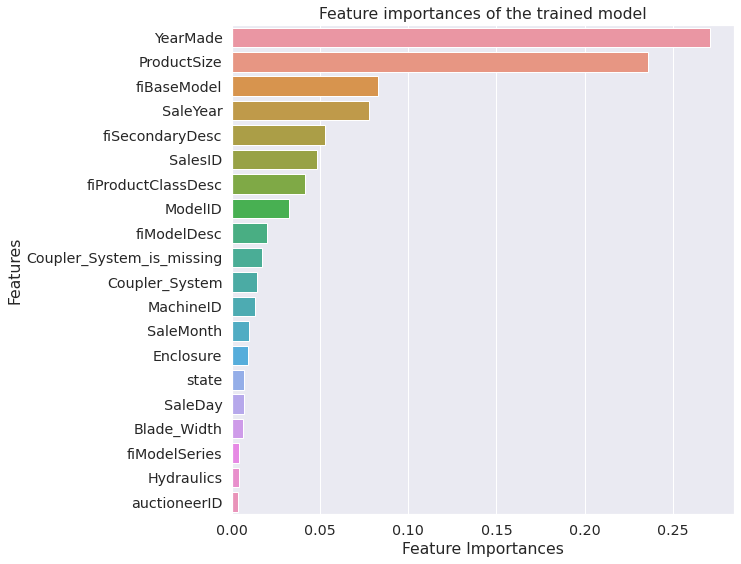

In [82]:
# plotting bar graph using Seaborn
# create figure
fig, ax = plt.subplots(figsize=(9, 9))
# set font size
sns.set(font_scale=1.3)
# create barplot
sns.barplot(data=feat_imp[:20], # using only 20 top features
            x="Feature Importances",
            y="Features",
            ax=ax,)
# title
ax.set_title("Feature importances of the trained model")

plt.show()

## 8. Further Experimentation & Analysis

The concepts explored in this notebook for this particular dataset & problem statement are very few & basic; But These are the common and potentially important things to do when exploring a structured dataset.  

In addition to these, the other ideas or concepts can be used to utilize this data and extract more insights.  
In this case, the trained machine learning model can be improved.  
There are various ways to do so, such as,

- Generally, Collecting more data would be very useful.
- Trying different algorithms to build a better model.
- More research & trying different hyperparameters for tuning the current model.

Spending more time to understand the problem and data helps, ALWAYS.  
Consulting a subject matter export(SEM) on the data would be great to see all the information in a productive way with the domain knowledge.  

As of now the model is achieving a reasonable RMSLE evaluation score as requested by Kaggle Bluebook for Bulldozers competition.  
Since that competition is ended a while ago, can only compare the RMSLE score results in the leaderboard.